# Customer Assignment Problem

Freely adapted from the original example by  ©Gurobi

## Motivation

Many companies in various industries must make strategic decisions about where to build facilities to support their operations. 
For example:

- Producers of goods need to decide how to design their **supply chains** – which encompass factories, distribution centers, warehouses, and retail stores.
- **Healthcare providers** need to determine where to build hospitals to maximize their population coverage.

These are strategic decisions that are difficult to implement and costly to change because they entail long-term investments. Furthermore, these decisions have a significant impact, both in terms of customer satisfaction and cost management. One of the critical factors to consider in this process is the location of the customers that the company is planning to serve.

---
## Problem Description

The Customer Assignment Problem is closely related to the Facility Location Problem, which is concerned with the optimal placement of facilities (from a set of candidate locations) in order to minimize the distance between the company's facilities and the customers. When the facilities have unlimited capacity, customers are assumed to be served by the closest facility. A threshold value determines the maximum distance of a customer from a facility.

In cases where the number of customers considered is too big, the customers can be grouped into clusters. Then, the cluster centers can be used in lieu of the individual customer locations. This pre-processing makes the assumption that all customers belonging to a given cluster will be served by the facility assigned to that cluster. The k-means algorithm can be used for this task, which aims to partition $n$ objects into $k$ distinct and non-overlapping clusters.

---
## Solution Approach

A mathematical optimization model has five components, namely:

- Sets and indices.
- Parameters.
- Decision variables.
- Objective function(s).
- Constraints.

We now present a **Binary Integer Programming** formulation to assign the **clusters** to the facilities:

### Sets and Indices:
- $i \in I$: Set of customer clusters. (If you want to assign the single customers substitute this set with the set of customers)

- $j \in J$: Set of potential facility locations.

- $\text{Pairings}= \{(i,j) \in I \times J: \text{dist}_{i,j} \leq \text{threshold}\}$: Set of allowed pairings

### Parameters:
- $\text{threshold} \in \mathbb{R}^+$: Maximum distance for a cluster-facility pairing to be considered.

- $\text{max_facilities} \in \mathbb{N}$: Maximum number of facilities to be opened.

- $\text{weight}_i \in \mathbb{N}$: Number of customers in cluster $i$.

- $\text{dist}_{i,j} \in \mathbb{R}^+$: Distance from cluster $i$ to facility location $j$.

### Decision Variables:
- $\text{y}_j \in \{0,1\}$: 1 if facility location $j$ is yed; 0 otherwise.

- $\text{x}_{i,j} \in \{0,1\}$: 1 if cluster $i$ is assigned to facility location $j$; 0 otherwise.

### Objective Function:

- **Total distance**: Minimize the total distance from clusters to their assigned facility:

\begin{equation}
\text{Min} \quad Z = \sum_{(i,j) \in \text{Pairings}}\text{weight}_i \cdot \text{dist}_{i,j} \cdot \text{x}_{i,j}
\tag{0}
\end{equation}


### Constraints:

- **Facility limit**: The number of facilities built cannot exceed the limit:

\begin{equation}
\sum_{j}\text{y}_j \leq \text{max_facilities}
\tag{1}
\end{equation}

- **Open to assign**: Cluster $i$ can only be assigned to facility $j$ if we decide to build that facility:

\begin{equation}
\text{x}_{i,j} \leq \text{y}_{j} \quad \forall (i,j) \in \text{Pairings}
\tag{2}
\end{equation}

- **Closest store**: Cluster $i$ must be assigned to exactly one facility:

\begin{equation}
\sum_{j:(i,j) \in \text{Pairings}}\text{x}_{i,j} = 1 \quad \forall i \in I
\tag{3}
\end{equation}


---
## Python Implementation


In [1]:
%matplotlib inline
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

seed = 10101
random.seed(seed)

### Dataset Generation

In this simple example, we choose random locations for customers and facility candidates. Customers are distributed using Gaussian distributions around a few randomly chosen population centers, whereas facility locations are uniformly distributed.

In [2]:
num_customers = 50000
num_candidate_facilities = 50
max_facilities = 8

num_gaussians = 10

In [3]:
# Make customer locations
customers_per_gaussian = np.random.multinomial(num_customers,
                                               [1/num_gaussians] * num_gaussians)
customer_locs = []
for num_customers_per_gaussian in customers_per_gaussian:
    # each center coordinate in [-0.5, 0.5]
    center = (random.random() - 0.5, random.random() - 0.5)
    customer_locs += [
        (random.gauss(0, .1) + center[0], random.gauss(0, .1) + center[1])
        for i in range(num_customers_per_gaussian)
    ]
#num_customers = 50000
#customer_locs = [ (random.random()-0.5, random.random() -0.5)  for i in range(num_customers)
#]    
print('Number of customer locations:', len(customer_locs))
print('First customer location:', customer_locs[0])

Number of customer locations: 50000
First customer location: (0.33164437091949245, -0.2809884943538464)


In [4]:
# Make candidate facility locations in [-0.5, 0.5]
facility_locs = [
    (random.random()-0.5, random.random()-0.5)
    for i in range(num_candidate_facilities)
]

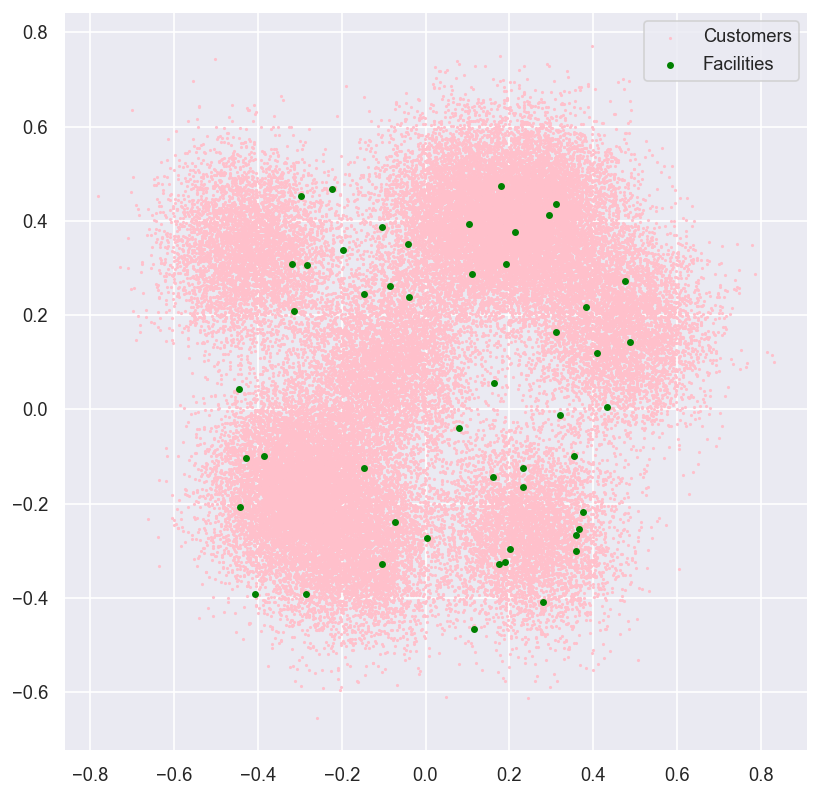

In [5]:
# visualize the data

plt.figure(figsize=(8,8), dpi=120)
plt.scatter(*zip(*customer_locs), c='Pink', label='Customers', s=0.8)
plt.scatter(*zip(*facility_locs), c='Green', label='Facilities', s=10)
# plt.text(-0.8,-0.8,"Pink=customers, Green=locations")
plt.legend()
plt.show()

### Preprocessing: clustering

To limit the size of the optimization model, we group individual customers into clusters and optimize on these clusters. Clusters are computed using the K-means algorithm, as implemented in the scikit-learn package.

In [6]:
from sklearn.cluster import MiniBatchKMeans, KMeans

clusters, inertias = [], []
min_inertia = float('inf')
for num_centers in range(800, 1150, 50):
    print('..',num_centers,end='')
    kmeans = MiniBatchKMeans(n_clusters=num_centers, 
                             init_size=3 * num_centers,
                             n_init='auto',
                             random_state=seed).fit(customer_locs)
    
    clusters.append(num_centers)
    inertias.append(kmeans.inertia_)
    if kmeans.inertia_ < min_inertia: 
        min_inertia = kmeans.inertia_ 
        num_clusters = num_centers
print('\nClustering terminated: min = ', num_clusters)

.. 800.. 850.. 900.. 950.. 1000.. 1050.. 1100
Clustering terminated: min =  1100


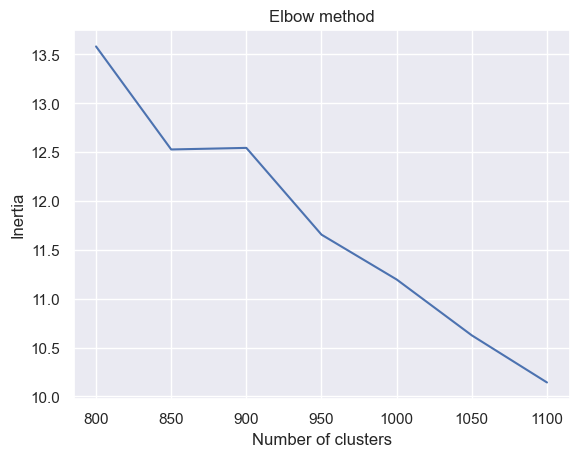

In [7]:
plt.plot(clusters, inertias)    
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method');

In [8]:
 #selects according to the elbow
num_clusters = 1050

In [9]:
# Fit the centroids
kmeans = MiniBatchKMeans(n_clusters=num_clusters, 
                         init_size=3 * num_clusters,
                         n_init='auto',
                         random_state=seed).fit(customer_locs)

centroids = list(kmeans.cluster_centers_)

#computes the weight of each cluster
weights = [0 for c in range(num_clusters)]
for i in range(len(customer_locs)):
    weights[kmeans.labels_[i]] += 1

            # Number of customers in each cluster
print('First cluster center:', centroids[0])
print('Weights for first 10 clusters:', weights[:10])

First cluster center: [0.30057449 0.48005039]
Weights for first 10 clusters: [48, 52, 80, 86, 77, 55, 37, 51, 95, 34]


### Preprocessing: viable Customer-Store Pairings

Some facilities are just too far away from a cluster center to be relevant, so let's heuristically filter all distances that exceed a given `threshold`:

In [10]:
threshold = 0.95

In [11]:
def dist(loc1, loc2):
    """
    Euclidean distance
    
    Args:
        :param loc1:
        :param loc2:
    """
    return np.linalg.norm(loc1 - loc2, ord=2)

pairings = {
    (facility, cluster): dist(facility_locs[facility], centroids[cluster])
    for facility in range(num_candidate_facilities)
        for cluster in range(num_clusters) 
            if  dist(facility_locs[facility], centroids[cluster]) < threshold
}
print("Number of viable pairings: {0}".format(len(pairings.keys())))

Number of viable pairings: 50165


###  Model Deployment

Build facilities from among candidate locations to minimize total distance to cluster centers:

In [12]:
import gurobipy as gp
from gurobipy import GRB

print(gp.gurobi.version())

(10, 0, 3)


In [13]:
print('cluster= ',num_clusters)
print('max_facilities= ',max_facilities)
m = gp.Model("Facility location")

# Decision variables: select facility locations
y = m.addVars(range(num_candidate_facilities), vtype=GRB.BINARY, name='y')
# Decision variables: assign customer clusters to a facility location
x = m.addVars(pairings.keys(), vtype=GRB.BINARY, name='x')

# Deploy Objective Function
# 0. Total distance
obj = gp.quicksum(weights[cluster] * pairings[facility, cluster] * x[facility, cluster]
                  for facility, cluster in pairings.keys())
m.setObjective(obj, GRB.MINIMIZE)

# 1. Facility limit
m.addConstr(y.sum() <= max_facilities, name="Facility_limit")

# 2. Open to assign
m.addConstrs((x[facility, cluster] <= y[facility]
              for facility, cluster in pairings.keys()),
             name="Open2assign")

# 3. Closest store
m.addConstrs((x.sum('*', cluster) == 1
             for cluster in range(num_clusters)),
            name="Closest_store")

# Find the optimal solution
m.optimize()

print('\n** terminated **')

cluster=  1050
max_facilities=  8
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-20
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 51216 rows, 50215 columns and 150545 nonzeros
Model fingerprint: 0x961dbc70
Variable types: 0 continuous, 50215 integer (50215 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-02, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Presolve time: 0.28s
Presolved: 51216 rows, 50215 columns, 150545 nonzeros
Variable types: 0 continuous, 50215 integer (50215 binary)
Found heuristic solution: objective 10818.378850
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relax

## Analysis

Let's plot a map with:

- Customer locations represented as small pink dots.
- Customer cluster centroids represented as large red dots.
- Facility location candidates represented as green dots. Notice that selected locations have black lines emanating from them towards each cluster that is likely to be served by that facility.
- Facility locations selected represented as large blue dots.

In [14]:
selected_facilities = [ facility_locs[i] for i in range(num_candidate_facilities) if y[i].x > 0]
print(f'Number of selected locations:', len(selected_facilities))

Number of selected locations: 8


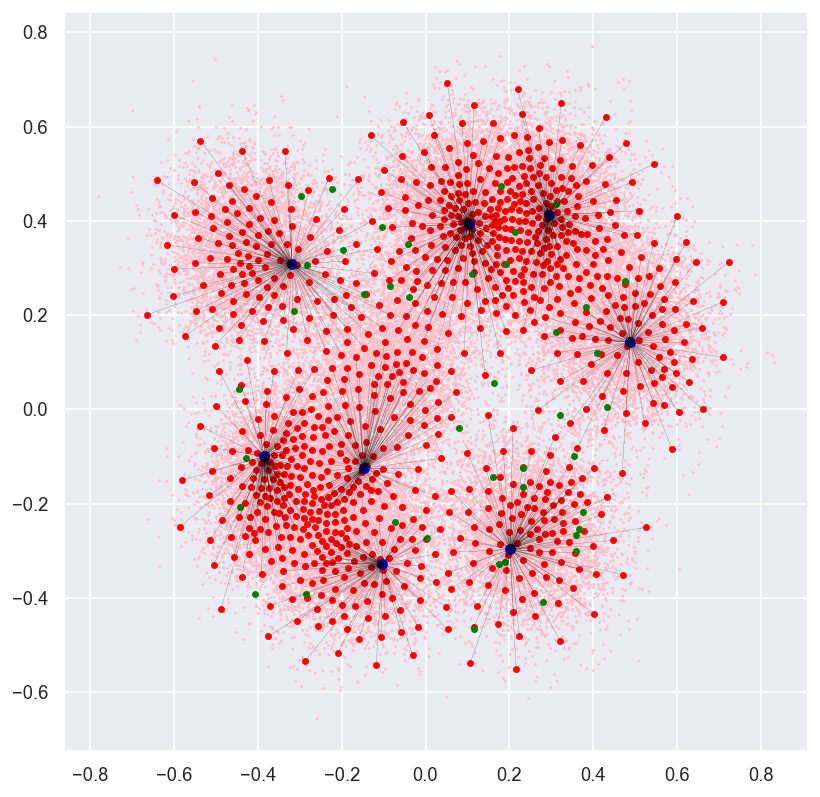

In [15]:
plt.figure(figsize=(8,8), dpi=120)
plt.scatter(*zip(*customer_locs), c='Pink', s=0.5)
plt.scatter(*zip(*centroids), c='Red', s=10)
plt.scatter(*zip(*facility_locs), c='Green', s=10)

assignments = [p for p in pairings if x[p].x > 0.5]
for p in assignments:
    pts = [facility_locs[p[0]], centroids[p[1]]]
    plt.plot(*zip(*pts), c='Black', linewidth=0.1)
    

plt.scatter(*zip(*selected_facilities), c='Blue', linewidth=0.45)


---
## References

1. Drezner, Z., & Hamacher, H. W. (Eds.). (2001). Facility location: applications and theory. Springer Science & Business Media.
2. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning. New York: springer.
3. Klose, A., & Drexl, A. (2005). Facility location models for distribution system design. European journal of operational research, 162(1), 4-29.

---
## Ex: try again and use a different clustering technique

How could you compare different solutions?